<a href="https://colab.research.google.com/github/lusiaulia/Prediksi_ISPU_BandarLampung/blob/main/Prediksi_ISPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
# Import library
import pandas as pd
import numpy as np
from numpy import array
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout

# Clone dan Buka Dataset

In [ ]:
# Clone dataset dari github
!git clone https://github.com/lusiaulia/Prediksi_ISPU_BandarLampung.git

Cloning into 'Prediksi_ISPU_BandarLampung'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 74
Receiving objects: 100% (78/78), 4.02 MiB | 1.79 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
# mendefinisikan dataframe
df = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/AQI_BDL_Maret-Okt.xlsx") #Data penyusun ISPU
dw = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/Weather_BDL_Maret-Okt.xlsx") #Data meteorologi

In [ ]:
df = df.drop(['Unnamed: 0'],axis=1)

In [ ]:
df['rh'] = dw['rh']
df['temp'] = dw['temp']
df['wind_spd'] = dw['wind_spd']


In [ ]:
df.describe()

,pm10,pm25,o3,so2,no2,co,rh,temp,wind_spd
count,5872.000000,5875.000000,5872.000000,5854.000000,5869.000000,5866.000000,5880.000000,5880.000000,5880.000000
mean,49.252256,41.987779,24.631480,2.201384,6.470257,794.071741,80.679932,26.564201,1.885861
std,40.401458,37.663592,23.824031,1.695862,3.817150,364.903872,11.849970,2.808715,1.192324
min,1.980000,1.090000,0.000000,0.000000,0.000000,0.000000,41.000000,21.400000,0.000000
25%,18.465000,13.240000,7.187500,1.100000,3.710000,505.520000,72.000000,24.200000,1.080000
50%,38.465000,30.860000,17.490000,1.680000,5.990000,747.560000,84.000000,25.900000,1.600000
75%,68.225000,58.130000,34.017500,2.747500,8.330000,1025.352500,90.000000,28.800000,2.400000
max,250.290000,226.020000,161.760000,14.130000,49.270000,2247.930000,100.000000,34.300000,22.100000


Berikut di atas merupakan statistik deskriptif dari data parameter ISPU dan data meteorologi.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5880 non-null   datetime64[ns]
 1   pm10      5872 non-null   float64       
 2   pm25      5875 non-null   float64       
 3   o3        5872 non-null   float64       
 4   so2       5854 non-null   float64       
 5   no2       5869 non-null   float64       
 6   co        5866 non-null   float64       
 7   rh        5880 non-null   int64         
 8   temp      5880 non-null   float64       
 9   wind_spd  5880 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 459.5 KB


##Praproses Data

In [ ]:
df_time = df["datetime"]
df = df.drop(['datetime'],axis=1)

0      2022-03-01 00:00:00
1      2022-03-01 01:00:00
2      2022-03-01 02:00:00
3      2022-03-01 03:00:00
4      2022-03-01 04:00:00
               ...        
5875   2022-10-31 19:00:00
5876   2022-10-31 20:00:00
5877   2022-10-31 21:00:00
5878   2022-10-31 22:00:00
5879   2022-10-31 23:00:00
Name: datetime, Length: 5880, dtype: datetime64[ns]

<Axes: >

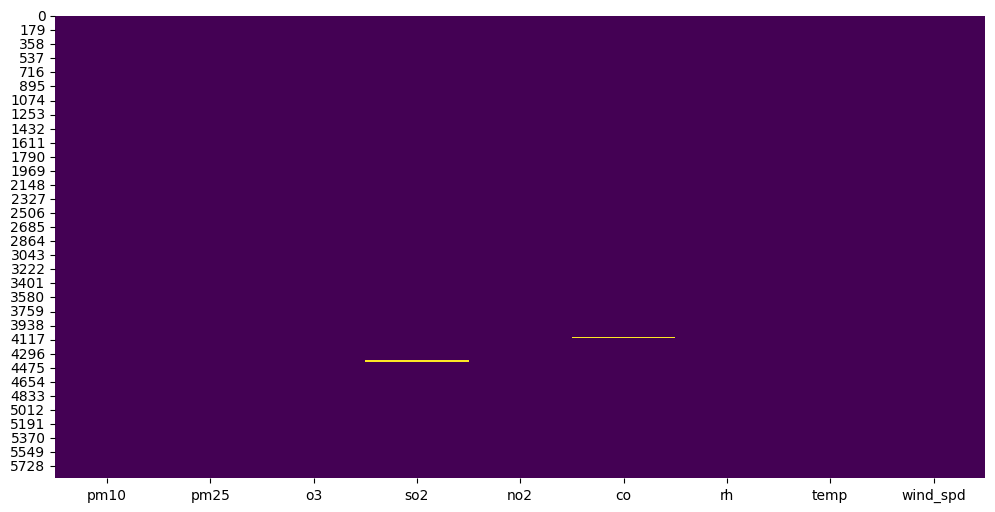

In [ ]:
# Plot null data
mpl.rcParams['figure.figsize'] = (12, 6)
# df = df.set_index('datetime')
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [ ]:
# Total null data
print(df.isnull().sum())
print('shape:', df.shape)

pm10         8
pm25         5
o3           8
so2         26
no2         11
co          14
rh           0
temp         0
wind_spd     0
dtype: int64
shape: (5880, 9)


Tidak ada data kosong pada data meteorologi

In [ ]:
#Mengisi Data Kosong dengan Nilai Mean
mean = df["pm25"].mean()
df["pm25"] = df["pm25"].replace(np.nan, mean)
mean = df["pm10"].mean()
df["pm10"] = df["pm10"].replace(np.nan, mean)
mean = df["so2"].mean()
df["so2"] = df["so2"].replace(np.nan, mean)
mean = df["co"].mean()
df["co"] = df["co"].replace(np.nan, mean)
mean = df["o3"].mean()
df["o3"] = df["o3"].replace(np.nan, mean)
mean = df["no2"].mean()
df["no2"] = df["no2"].replace(np.nan, mean)

<Axes: >

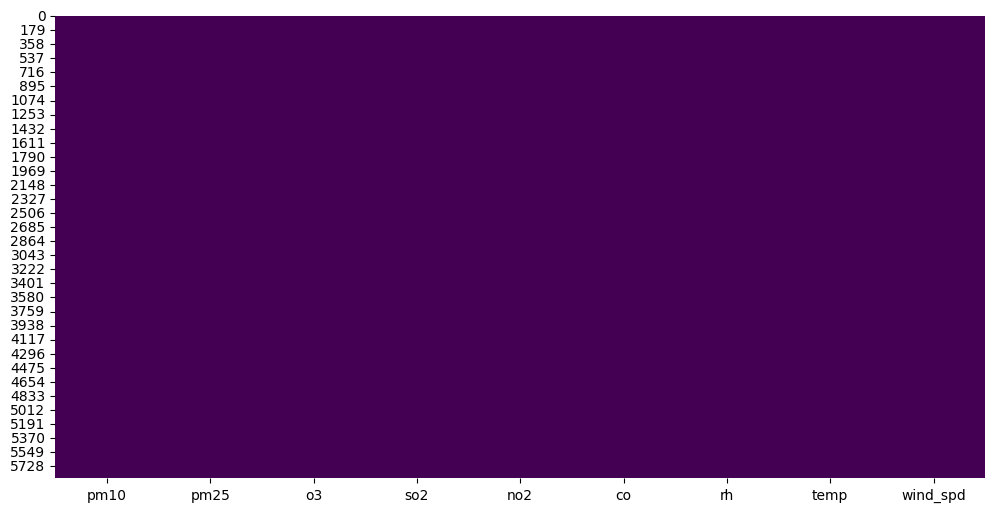

In [ ]:
#Visualisasi Heatmap Setelah Pengisian Data Kosong
mpl.rcParams['figure.figsize'] = (12, 6)
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm10      5880 non-null   float64
 1   pm25      5880 non-null   float64
 2   o3        5880 non-null   float64
 3   so2       5880 non-null   float64
 4   no2       5880 non-null   float64
 5   co        5880 non-null   float64
 6   rh        5880 non-null   int64  
 7   temp      5880 non-null   float64
 8   wind_spd  5880 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 413.6 KB
None


In [ ]:
plot_cols = ['pm10','pm25','o3','so2','no2','co','rh','temp','wind_spd']
df = df[plot_cols]

,pm10,pm25,o3,so2,no2,co,rh,temp,wind_spd
0,60.67,39.19,3.32,1.87,8.61,1062.05,87,23.8,0.52
1,60.94,41.31,3.18,1.31,7.74,1059.94,88,23.4,1.30
2,50.38,35.28,4.92,1.10,7.39,946.69,90,23.2,2.10
3,39.82,29.25,6.66,0.89,7.03,833.43,91,22.8,2.60
4,29.25,23.23,8.40,0.67,6.68,720.18,91,22.8,2.63
...,...,...,...,...,...,...,...,...,...
5875,9.57,4.34,35.93,1.34,4.56,357.30,63,28.6,3.20
5876,11.48,5.26,33.77,1.31,4.75,376.79,84,24.0,2.78
5877,13.40,6.18,31.61,1.28,4.94,396.29,86,23.6,2.67
5878,15.32,7.10,29.45,1.25,5.13,415.79,70,26.0,2.80


Sekarang kita lihat apakah ada outliers. Outliers harus kita antisipasi karna outliers itu dapat meningkatkan nilai error dan bias, khususnya saat
kita menerapkan uji statistik pada data. Saat kita memiliki banyak data dan sedikit outlier, Sampel lain tidak akan dirugikan dengan
menghapus outlier yang meragukan.

In [ ]:
def get_outliers(df):

    # Menghitung 25th dan 75th percentile
    p75 = df.quantile(0.75)
    p25 = df.quantile(0.25)
    # Menghitung IQR dengan selisih 25th dan 75th percentile
    iqr = p75 - p25

    # "Minimum non-outlier value": 25th percentile - 1.5 * IQR
    min_val = p25 - 1.5*iqr
    # "Maximum non-outlier value": 75th percentile + 1.5 * IQR
    max_val = p75 + 1.5*iqr

    # Apapun dibawah minimum atau diatas maximum, disebut sebagai outlier
    outliers = df[(df < min_val) | (df > max_val)]
    return outliers

def replace_outliers(df,ds):
  m = df.mean()
  for x in df:
    for i in ds:
      if x == i:
        df = df.replace(x,m)
  return df

In [ ]:
    p75 = df.quantile(0.75)
    p25 = df.quantile(0.25)
    # Menghitung IQR dengan selisih 25th dan 75th percentile
    iqr = p75 - p25

    # "Minimum non-outlier value": 25th percentile - 1.5 * IQR
    # max_val = p75 + 1.5*iqr
    # max_val
    min_val = p25 - 1.5*iqr
    min_val

pm10        -56.03625
pm25        -54.00625
o3          -32.99500
so2          -1.34875
no2          -3.18625
co         -269.47125
rh           45.00000
temp         17.30000
wind_spd     -0.90000
dtype: float64

In [ ]:
a,b,c = get_outliers(df.pm10),get_outliers(df.pm25),get_outliers(df.no2)
d,e,f = get_outliers(df.co),get_outliers(df.so2),get_outliers(df.o3)
g,h,i = get_outliers(df.rh),get_outliers(df.temp),get_outliers(df.wind_spd)
print(f"{round(((len(a)/len(df.pm10)))*100)}% atau {len(a)} outliers dari total {len(df.pm10)} data")
print(f"{round((len(b)/len(df.pm25))*100)}% atau {len(b)} outliers dari total {len(df.pm25)} data")
print(f"{round((len(c)/len(df.no2))*100)}% atau {len(c)} outliers dari total {len(df.no2)} data")
print(f"{round((len(d)/len(df.co))*100)}% atau {len(d)} outliers dari total {len(df.co)} data")
print(f"{round((len(e)/len(df.so2))*100)}% atau {len(e)} outliers dari total {len(df.so2)} data")
print(f"{round((len(f)/len(df.o3))*100)}% atau {len(f)} outliers dari total {len(df.o3)} data")
print(f"{round((len(g)/len(df.rh))*100)}% atau {len(g)} outliers dari total {len(df.rh)} data")
print(f"{round((len(h)/len(df.temp))*100)}% atau {len(h)} outliers dari total {len(df.temp)} data")
print(f"{round((len(i)/len(df.wind_spd))*100)}% atau {len(i)} outliers dari total {len(df.wind_spd)} data")

3% atau 199 outliers dari total 5880 data
4% atau 243 outliers dari total 5880 data
3% atau 154 outliers dari total 5880 data
1% atau 55 outliers dari total 5880 data
6% atau 344 outliers dari total 5880 data
5% atau 303 outliers dari total 5880 data
0% atau 8 outliers dari total 5880 data
0% atau 0 outliers dari total 5880 data
3% atau 199 outliers dari total 5880 data


Nilai outlier dari masing masing data semuanya memiliki presentase yang sedikit sehingga dapat kita abaikan. Sekarang kita cek untuk korelasi.

Waktunya untuk cek korelasinya. Korelasi memiliki rentang sebagai berikut :
*   0 : Tidak ada korelasi antar variabel
*   0-0.25 : Korelasi sangat lemah
*   0.25-0.5 : Korelasi cukup
*   0.5-0.75 : Korelasi kuat
*   1 : Korelasi hubungan sempurna positif
*  -1 : Korelasi hubungan sempurna negatif








In [ ]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# scaled
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# split dataset to train and test
total_dataset = len(df)
df_train = df_scaled[:int(total_dataset*0.80)]
df_test = df_scaled[int(total_dataset*0.80):total_dataset]

print('Data for train:', df_train.shape)
print('Total day for train:', round(df_train.shape[0]/24))
print('\nData for test:', df_test.shape)
print('Total day for test:', round(df_test.shape[0]/24))

Data for train: (4704, 9)
Total day for train: 196

Data for test: (1176, 9)
Total day for test: 49


In [ ]:
# Choose a number of time steps
# n_steps_in history data for predict n_steps_out forecast data
n_steps_in, n_steps_out = 24,1

# Convert into input/output
x_train, y_train = split_sequences(df_train, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(df_test, n_steps_in, n_steps_out)

# The dataset knows the number of features, e.g. 2
n_features = x_train.shape[2]

In [ ]:
# Look at the x_train structure
print('Data input structure for training')
print(x_train[0])

print('\nData output structure for validation')
print(y_test[0])

Data input structure for training
[[0.23635778 0.16938603 0.02052423 0.13234253 0.17475137 0.47245688
  0.77966102 0.18604651 0.02352941]
 [0.23744513 0.17881119 0.01965875 0.09271054 0.15709357 0.47151824
  0.79661017 0.15503876 0.05882353]
 [0.19491764 0.15200285 0.03041543 0.07784855 0.14998985 0.42113856
  0.83050847 0.13953488 0.09502262]
 [0.15239016 0.1251945  0.04117211 0.06298655 0.14268317 0.37075443
  0.84745763 0.10852713 0.11764706]
 [0.1098224  0.09843062 0.05192878 0.04741684 0.13557946 0.32037474
  0.84745763 0.10852713 0.11900452]
 [0.09967379 0.08842751 0.053227   0.05237084 0.12401055 0.30274964
  0.81355932 0.10852713 0.10452489]
 [0.08952519 0.0784244  0.05452522 0.05661713 0.11264461 0.28512454
  0.77966102 0.11627907 0.09411765]
 [0.07937659 0.06846574 0.05588526 0.06086341 0.10107571 0.26750388
  0.74576271 0.17829457 0.08597285]
 [0.07716161 0.06424221 0.0754822  0.07006369 0.09823422 0.2653241
  0.62711864 0.24031008 0.08914027]
 [0.07494664 0.06001867 0.09514

In [ ]:
print('Total features:', n_features)
print('Total train data:', x_train.shape)
print('Total validation train data:', y_train.shape)
print('Total test data:', x_test.shape)
print('Total validation test data:', y_test.shape)

Total features: 9
Total train data: (4680, 24, 9)
Total validation train data: (4680, 1, 9)
Total test data: (1152, 24, 9)
Total validation test data: (1152, 1, 9)


# Train

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100,input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_features)))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               44000     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 time_distributed (TimeDistr  (None, 1, 9)             909       
 ibuted)                                                         
                                                                 
Total params: 125,309
Trainable params: 125,309
Non-trainable params: 0
_________________________________________________________________


#Tune the Initial Weight


In [ ]:
# Get initial weights
init_weights = model.get_weights()

Untuk mengambil nilai bias dan bobot parameter pada layer ke 0

In [ ]:
first_layer_weights = model.layers[0].get_weights()[0]
print('Nilai Weight')
print(first_layer_weights)
first_layer_biases = model.layers[0].get_weights()[1]
print('Nilai Bias')
print(first_layer_biases)

Nilai Weight
[[-0.04600173  0.05767818  0.11914486 ... -0.04497899 -0.05512957
   0.00081939]
 [ 0.03813948  0.11479625  0.03012671 ...  0.00046518 -0.07679588
   0.00717621]
 [-0.06875549  0.06161185 -0.04176049 ...  0.0684973  -0.10670891
   0.0625632 ]
 ...
 [ 0.04782313 -0.05539806  0.0028325  ...  0.07185312  0.04449385
  -0.11689414]
 [ 0.08225738 -0.1147522  -0.03266884 ...  0.04566382  0.04301667
  -0.03628859]
 [ 0.03133042  0.00592983  0.09859519 ...  0.04353796 -0.08297832
   0.02216366]]
Nilai Bias
[[ 0.03034472  0.07056021 -0.01795494 ...  0.02546876 -0.04574129
  -0.04029001]
 [-0.00063745  0.05128646  0.01923879 ...  0.00880098  0.0194836
  -0.0235216 ]
 [ 0.03129818  0.01740607  0.08274496 ... -0.06147973  0.07168236
   0.00604111]
 ...
 [ 0.02643735 -0.02837353 -0.05299988 ...  0.04307485  0.0719905
  -0.07813895]
 [-0.04166652  0.03609869 -0.03909805 ...  0.03858642 -0.0158237
  -0.10348227]
 [-0.02923597 -0.0405876   0.06763098 ...  0.04315295  0.11373046
  -0.039147

In [ ]:
bobot = pd.DataFrame(first_layer_weights)
bias = pd.DataFrame(first_layer_biases)

In [ ]:
print(bobot.shape)
print(bias.shape)

(9, 400)
(100, 400)


In [ ]:
file_name = "Bobot.xlsx"
bobot.to_excel(file_name, header=True)
file_name = "Bias.xlsx"
bias.to_excel(file_name, header=True)

In [ ]:
# fit mode
epoch = 50
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse',
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test))


Epoch 1/50
147/147 [==============================] - 16s 13ms/step - loss: 0.0182 - mean_absolute_error: 0.0880 - val_loss: 0.0058 - val_mean_absolute_error: 0.0516
Epoch 2/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0037 - mean_absolute_error: 0.0422 - val_loss: 0.0042 - val_mean_absolute_error: 0.0406
Epoch 3/50
147/147 [==============================] - 1s 8ms/step - loss: 0.0022 - mean_absolute_error: 0.0326 - val_loss: 0.0042 - val_mean_absolute_error: 0.0377
Epoch 4/50
147/147 [==============================] - 1s 8ms/step - loss: 0.0018 - mean_absolute_error: 0.0290 - val_loss: 0.0041 - val_mean_absolute_error: 0.0344
Epoch 5/50
147/147 [==============================] - 1s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0265 - val_loss: 0.0043 - val_mean_absolute_error: 0.0340
Epoch 6/50
147/147 [==============================] - 1s 8ms/step - loss: 0.0014 - mean_absolute_error: 0.0245 - val_loss: 0.0045 - val_mean_absolute_error: 0.0337
Epoch 7/50
147

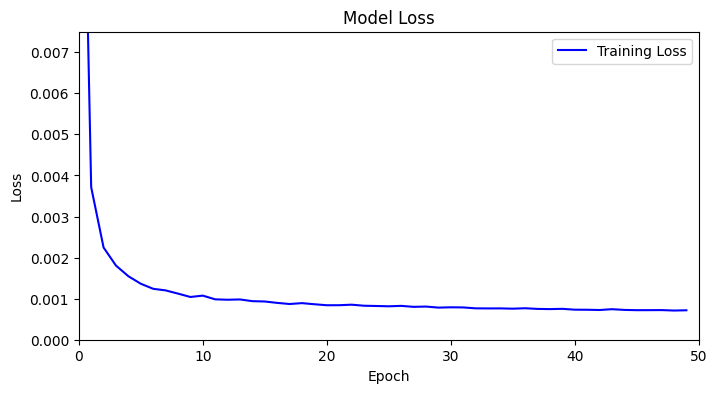

In [ ]:
#Loss Curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.axis([0, 50, 0.0, 0.0075])
plt.title('Model Loss')
plt.legend(loc=0)
# plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(loc='upper righConvertISPU(dp)t')
plt.show();

# Test model


In [ ]:
predictions = model.predict(x_test)
print(predictions.shape)
print(y_test.shape)

36/36 [==============================] - 1s 3ms/step
(1152, 1, 9)
(1152, 1, 9)


In [ ]:
 # reshape according to predictions shape
predictions = np.reshape(predictions, (1152*1, 9))
real = np.reshape(y_test, (1152*1, 9))

# rescale predictions
predictions = pd.DataFrame(predictions)
predictions = scaler.inverse_transform(predictions)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: "pm10", 1: "pm25",
                                          2: "o3", 3: "so2",
                                          4: "no2", 5: "co", 6:"rh",7:"temp",8:"wind"})

real = pd.DataFrame(real)
real = scaler.inverse_transform(real)
real = pd.DataFrame(real)

print(predictions.shape)
print(real.shape)

(1152, 9)
(1152, 9)


In [ ]:
predictions

,pm10,pm25,o3,so2,no2,co,rh,temp,wind
0,24.050533,17.133535,19.110552,0.932116,5.400741,572.556763,78.511688,25.652657,3.278020
1,18.814833,13.102345,18.205431,0.755338,4.696293,497.814728,79.149368,25.419863,2.835142
2,14.037449,9.060198,17.534731,0.564581,3.928844,423.958984,81.148773,24.990698,2.816338
3,14.398322,9.273322,16.859795,0.610657,3.769407,415.763855,82.165482,24.565250,2.462101
4,14.238013,8.920539,16.175003,0.593327,3.544694,402.937866,83.287979,24.255159,2.156728
...,...,...,...,...,...,...,...,...,...
1147,11.787004,5.972392,35.439491,1.318975,4.661135,357.318756,81.901794,24.344187,2.842111
1148,11.055121,5.538166,30.724155,1.426808,5.474800,381.828674,63.600880,28.695290,2.887448
1149,16.136578,8.690536,28.352943,1.338986,5.664934,437.638245,88.142487,23.000971,2.368625
1150,15.142658,7.421928,31.108128,1.171891,4.838342,391.885834,88.014336,23.454336,2.397011


In [ ]:
df_t = df_time[int(len(df)*0.8) : ]
df_t1 = df_t[4:]
df_t1

4708   2022-09-13 04:00:00
4709   2022-09-13 05:00:00
4710   2022-09-13 06:00:00
4711   2022-09-13 07:00:00
4712   2022-09-13 08:00:00
               ...        
5875   2022-10-31 19:00:00
5876   2022-10-31 20:00:00
5877   2022-10-31 21:00:00
5878   2022-10-31 22:00:00
5879   2022-10-31 23:00:00
Name: datetime, Length: 1172, dtype: datetime64[ns]

In [ ]:
df_t1.iloc[1]

Timestamp('2022-09-13 05:00:00')

In [ ]:
len(df)*0.8

4704.0

In [ ]:
real

,0,1,2,3,4,5,6,7,8
0,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20
1,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20
2,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80
3,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40
4,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40
...,...,...,...,...,...,...,...,...,...
1147,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20
1148,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78
1149,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67
1150,15.32,7.10,29.45,1.25,5.13,415.79,70.0,26.0,2.80


In [ ]:
df_final = pd.DataFrame()

In [ ]:
df_final['pm10'] = real[0]
df_final['pm25'] = real[1]
df_final['o3'] = real[2]
df_final['so2'] = real[3]
df_final['no2'] = real[4]
df_final['co'] = real[5]
df_final['rh'] = real[6]
df_final['temp'] = real[7]
df_final['wind'] = real[8]

df_final['pm10_lstm'] = predictions.pm10
df_final['pm25_lstm'] = predictions.pm25
df_final['o3_lstm'] = predictions.o3
df_final['so2_lstm'] = predictions.so2
df_final['no2_lstm'] = predictions.no2
df_final['co_lstm'] = predictions.co
df_final['rh_lstm'] = predictions.rh
df_final['temp_lstm'] = predictions.temp
df_final['wind_lstm'] = predictions.wind

In [ ]:
df_final

,pm10,pm25,o3,so2,no2,co,rh,temp,wind,pm10_lstm,pm25_lstm,o3_lstm,so2_lstm,no2_lstm,co_lstm,rh_lstm,temp_lstm,wind_lstm
0,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20,24.050533,17.133535,19.110552,0.932116,5.400741,572.556763,78.511688,25.652657,3.278020
1,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20,18.814833,13.102345,18.205431,0.755338,4.696293,497.814728,79.149368,25.419863,2.835142
2,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80,14.037449,9.060198,17.534731,0.564581,3.928844,423.958984,81.148773,24.990698,2.816338
3,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40,14.398322,9.273322,16.859795,0.610657,3.769407,415.763855,82.165482,24.565250,2.462101
4,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40,14.238013,8.920539,16.175003,0.593327,3.544694,402.937866,83.287979,24.255159,2.156728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20,11.787004,5.972392,35.439491,1.318975,4.661135,357.318756,81.901794,24.344187,2.842111
1148,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78,11.055121,5.538166,30.724155,1.426808,5.474800,381.828674,63.600880,28.695290,2.887448
1149,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67,16.136578,8.690536,28.352943,1.338986,5.664934,437.638245,88.142487,23.000971,2.368625
1150,15.32,7.10,29.45,1.25,5.13,415.79,70.0,26.0,2.80,15.142658,7.421928,31.108128,1.171891,4.838342,391.885834,88.014336,23.454336,2.397011


In [ ]:
df_final["datetime"] = df_final.pm10
# df_final

In [ ]:
df_final

,pm10,pm25,o3,so2,no2,co,rh,temp,wind,pm10_lstm,pm25_lstm,o3_lstm,so2_lstm,no2_lstm,co_lstm,rh_lstm,temp_lstm,wind_lstm,datetime
0,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20,24.050533,17.133535,19.110552,0.932116,5.400741,572.556763,78.511688,25.652657,3.278020,21.08
1,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20,18.814833,13.102345,18.205431,0.755338,4.696293,497.814728,79.149368,25.419863,2.835142,15.56
2,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80,14.037449,9.060198,17.534731,0.564581,3.928844,423.958984,81.148773,24.990698,2.816338,13.95
3,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40,14.398322,9.273322,16.859795,0.610657,3.769407,415.763855,82.165482,24.565250,2.462101,12.34
4,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40,14.238013,8.920539,16.175003,0.593327,3.544694,402.937866,83.287979,24.255159,2.156728,10.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20,11.787004,5.972392,35.439491,1.318975,4.661135,357.318756,81.901794,24.344187,2.842111,9.57
1148,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78,11.055121,5.538166,30.724155,1.426808,5.474800,381.828674,63.600880,28.695290,2.887448,11.48
1149,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67,16.136578,8.690536,28.352943,1.338986,5.664934,437.638245,88.142487,23.000971,2.368625,13.40
1150,15.32,7.10,29.45,1.25,5.13,415.79,70.0,26.0,2.80,15.142658,7.421928,31.108128,1.171891,4.838342,391.885834,88.014336,23.454336,2.397011,15.32


In [ ]:
for i in range(0,len(df_final)):
   df_final.datetime.iloc[i] = df_t1.iloc[i]

<ipython-input-65-ff2904448608>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.datetime.iloc[i] = df_t1.iloc[i]


In [ ]:
# df_final["datetime"].apply(pd.Timestamp)
# df_final

In [ ]:
df_final = df_final.set_index('datetime')
# df_final

In [ ]:
df_final

,pm10,pm25,o3,so2,no2,co,rh,temp,wind,pm10_lstm,pm25_lstm,o3_lstm,so2_lstm,no2_lstm,co_lstm,rh_lstm,temp_lstm,wind_lstm
datetime,,,,,,,,,,,,,,,,,,
2022-09-13 04:00:00,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20,24.050533,17.133535,19.110552,0.932116,5.400741,572.556763,78.511688,25.652657,3.278020
2022-09-13 05:00:00,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20,18.814833,13.102345,18.205431,0.755338,4.696293,497.814728,79.149368,25.419863,2.835142
2022-09-13 06:00:00,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80,14.037449,9.060198,17.534731,0.564581,3.928844,423.958984,81.148773,24.990698,2.816338
2022-09-13 07:00:00,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40,14.398322,9.273322,16.859795,0.610657,3.769407,415.763855,82.165482,24.565250,2.462101
2022-09-13 08:00:00,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40,14.238013,8.920539,16.175003,0.593327,3.544694,402.937866,83.287979,24.255159,2.156728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-30 23:00:00,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20,11.787004,5.972392,35.439491,1.318975,4.661135,357.318756,81.901794,24.344187,2.842111
2022-10-31 00:00:00,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78,11.055121,5.538166,30.724155,1.426808,5.474800,381.828674,63.600880,28.695290,2.887448
2022-10-31 01:00:00,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67,16.136578,8.690536,28.352943,1.338986,5.664934,437.638245,88.142487,23.000971,2.368625


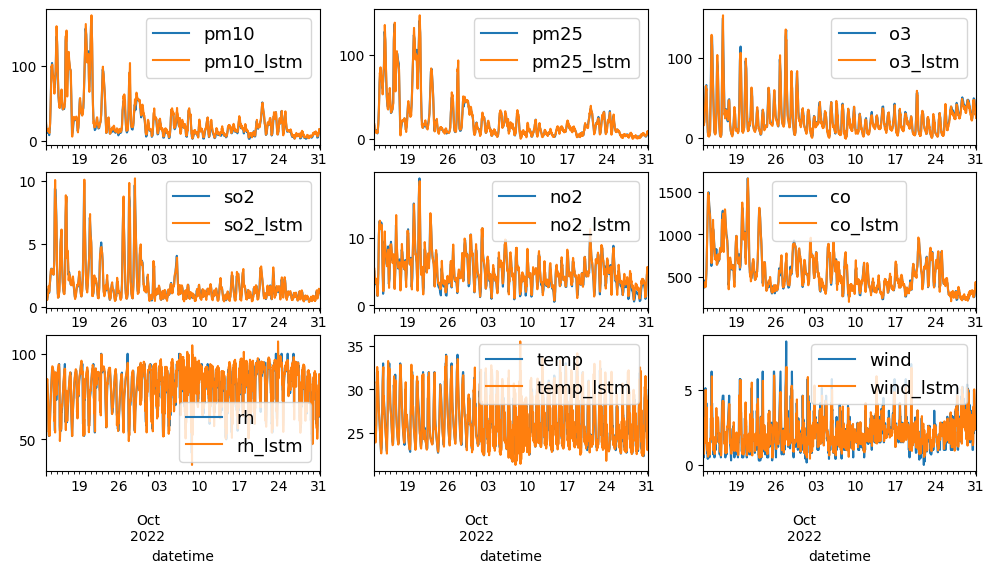

<Figure size 900x300 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(3,3) # create 3x3 array of subplots
fig = mpl.pyplot.gcf()
mpl.rcParams['axes.grid'] = False
# fig.set_size_inches(18.5, 10.5)
plt.figure(figsize=(9,3))
# mpl.rcParams.update(mpl.rcParamsDefault)
# fig.set_size_inches(8.90, 1.18)
# plt.figure(figsize=(10,6))
plt.rcParams.update({
        "font.size": 13,})

df_final[['pm10', 'pm10_lstm']].plot(ax=axes[0,0]) # add boxplot to 1st subplot
df_final[['pm25', 'pm25_lstm']].plot(ax=axes[0,1]) # add boxplot to 2nd subplot
df_final[['o3', 'o3_lstm']].plot(ax=axes[0,2]) # add boxplot to 1st subplot
df_final[['so2', 'so2_lstm']].plot(ax=axes[1,0]) # add boxplot to 2nd subplot
df_final[['no2', 'no2_lstm']].plot(ax=axes[1,1]) # add boxplot to 1st subplot
df_final[['co', 'co_lstm']].plot(ax=axes[1,2]) # add boxplot to 2nd subplot
df_final[['rh', 'rh_lstm']].plot(ax=axes[2,0]) # add boxplot to 2nd subplot
df_final[['temp', 'temp_lstm']].plot(ax=axes[2,1]) # add boxplot to 1st subplot
df_final[['wind', 'wind_lstm']].plot(ax=axes[2,2]) # add boxplot to 2nd subplot
# etc.
plt.show()

## error metric result

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

indicator = ['pm10', 'pm25','so2', 'no2', 'o3','co','rh','temp','wind']
for i in indicator:
  rmse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_lstm'], squared=False)
  mse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_lstm'])
  mae = mean_absolute_error(df_final[f'{i}'], df_final[f'{i}_lstm'])
  mape = mean_absolute_percentage_error(df_final[f'{i}'], df_final[f'{i}_lstm'])
  print(f'{i} ----> RMSE: {rmse} ; MSE: {mse} ; MAE: {mae} ; MAPE: {mape}\n')

# # print('-----'*23)'

pm10 ----> RMSE: 3.446448030041598 ; MSE: 11.87800402377761 ; MAE: 2.3747943212588627 ; MAPE: 0.14915093280674238

pm25 ----> RMSE: 2.793981670005708 ; MSE: 7.806333572327883 ; MAE: 1.7375590949047022 ; MAPE: 0.14485759343171847

so2 ----> RMSE: 0.21446002205571565 ; MSE: 0.04599310106013805 ; MAE: 0.1284131662889073 ; MAPE: 0.08418521403584156

no2 ----> RMSE: 0.5267816209870438 ; MSE: 0.2774988762097375 ; MAE: 0.4095726622765263 ; MAPE: 0.1242544741306381

o3 ----> RMSE: 3.3139185736710246 ; MSE: 10.982056312921799 ; MAE: 2.3450357086052342 ; MAPE: 0.12975507959287402

co ----> RMSE: 33.66705668934943 ; MSE: 1133.4707061238682 ; MAE: 25.480264176792566 ; MAPE: 0.05174201097178593

rh ----> RMSE: 8.263277131838695 ; MSE: 68.28174895756833 ; MAE: 5.3170958161354065 ; MAPE: 0.0697559297812747

temp ----> RMSE: 1.6422864353083801 ; MSE: 2.6971047355979065 ; MAE: 1.0611156698730255 ; MAPE: 0.0401938405281655

wind ----> RMSE: 0.9145864299507046 ; MSE: 0.8364683378499751 ; MAE: 0.656073058

# Convert ISPU Prediksi



In [ ]:
predictions["ISPU"] = predictions.pm10
predictions["ISPU_pm10"] = predictions.pm10
predictions["ISPU_pm25"] = predictions.pm10
predictions["ISPU_o3"] = predictions.pm10
predictions["ISPU_so2"] = predictions.pm10
predictions["ISPU_no2"] = predictions.pm10
predictions["ISPU_co"] = predictions.pm10

In [ ]:
def ConvertPM10(predictions):
    for i in range(0, len(predictions)):
      q1 = predictions.pm10.iloc[i] #pm10
      if q1 > 420:
        k, t , r = (q1 - 420),(500 - 420), (400 - 300)
        ISPU_pm10 = (r*k/t) + 300
      elif 350 < q1 <= 420:
        k, t , r = (q1 - 350),(420 - 350), (300 - 200)
        ISPU_pm10 = (r*k/t) + 200
      elif 150 < q1 <= 350:
        k, t , r = (q1 - 150),(350 - 150), (200 - 100)
        ISPU_pm10 = (r*k/t) + 100
      else :
        k, t , r = (q1 - 50),(150 - 50), (100 - 50)
        ISPU_pm10 = (r*k/t) + 50
      predictions.ISPU_pm10.iloc[i] = round(ISPU_pm10)

def ConvertPM25(predictions):
    for i in range(0, len(predictions)):
      q2 = predictions.pm25.iloc[i] #pm2,5
      if q2 > 250.4:
        k, t , r = (q2 - 250.4),(500 - 250.4), (400 - 300)
        ISPU_pm25 = (r*k/t) + 300
      elif 150.4 < q2 <= 250.4:
        k, t , r = (q2 - 150.4),(250.4 - 150.4), (300 - 200)
        ISPU_pm25 = (r*k/t) + 200
      elif 55.4 < q2 <= 150.4:
        k, t , r = (q2 - 55.4),(150.4 - 55.4), (200 - 100)
        ISPU_pm25 = (r*k/t) + 100
      else :
        k, t , r = (q2 - 15.5),(55.4 - 15.5), (100 - 50)
        ISPU_pm25 = (r*k/t) + 50
      predictions.ISPU_pm25.iloc[i] = round(ISPU_pm25)

def ConvertO3(predictions):
    for i in range(0, len(predictions)):
      q3 = predictions.o3.iloc[i] #o3
      if q3 > 800:
        k, t , r = (q3 - 800),(1000 - 800), (400 - 300)
        ISPU_o3 = (r*k/t) + 300
      elif 400 < q3 <= 800:
        k, t , r = (q3 - 400),(800 - 400), (300 - 200)
        ISPU_o3 = (r*k/t) + 200
      elif 235 < q3 <= 400:
        k, t , r = (q3 - 235),(400 - 235), (200 - 100)
        ISPU_o3 = (r*k/t) + 100
      else :
        k, t , r = (q3 - 120),(235 - 120), (100 - 50)
        ISPU_o3 = (r*k/t) + 50
      predictions.ISPU_o3.iloc[i] = round(ISPU_o3)

def ConvertSO2(predictions):
    for i in range(0, len(predictions)):
      q4 = predictions.so2.iloc[i] #so2
      if q4 > 800:
        k, t , r = (q4 - 800),(1200 - 800), (400 - 300)
        ISPU_so2 = (r*k/t) + 300
      elif 400< q4 <= 800:
        k, t , r = (q4 - 400),(800 - 400), (300 - 200)
        ISPU_so2 = (r*k/t) + 200
      elif 180 < q4 <= 400:
        k, t , r = (q4 - 180),(400 - 180), (200 - 100)
        ISPU_so2 = (r*k/t) + 100
      else :
        k, t , r = (q4 - 52),(180 - 52), (100 - 50)
        ISPU_so2 = (r*k/t) + 50
      predictions.ISPU_so2.iloc[i] = round(ISPU_so2)

def ConvertNO2(predictions):
    for i in range(0, len(predictions)):
      q5 = predictions.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      predictions.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertNO2(predictions):
    for i in range(0, len(predictions)):
      q5 = predictions.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      predictions.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertCO(predictions):
    for i in range(0, len(predictions)):
      q6 = predictions.co.iloc[i] #co
      if q6 > 30000 :
        k, t , r = (q6 - 30000),(45000 - 30000), (400 - 300)
        ISPU_co = (r*k/t) + 300
      elif 15000 < q6 <= 30000 :
        k, t , r = (q6 - 15000),(30000 - 15000), (300 - 200)
        ISPU_co = (r*k/t) + 200
      elif 8000 < q6 <= 15000 :
        k, t , r = (q6 - 8000),(15000 - 8000), (200 - 100)
        ISPU_co = (r*k/t) + 100
      else :
        k, t , r = (q6 - 4000),(8000 - 4000), (100 - 50)
        ISPU_co = (r*k/t) + 50
      predictions.ISPU_co.iloc[i] = round(ISPU_co)

In [ ]:
ConvertPM10(predictions)
ConvertPM25(predictions)
ConvertO3(predictions)
ConvertSO2(predictions)
ConvertNO2(predictions)
ConvertCO(predictions)

In [ ]:
predictions

,pm10,pm25,o3,so2,no2,co,rh,temp,wind,ISPU,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co
0,24.050533,17.133535,19.110552,0.932116,5.400741,572.556763,78.511688,25.652657,3.278020,24.050533,37.0,52.0,6.0,30.0,26.0,7.0
1,18.814833,13.102345,18.205431,0.755338,4.696293,497.814728,79.149368,25.419863,2.835142,18.814833,34.0,47.0,6.0,30.0,26.0,6.0
2,14.037449,9.060198,17.534731,0.564581,3.928844,423.958984,81.148773,24.990698,2.816338,14.037449,32.0,42.0,5.0,30.0,25.0,5.0
3,14.398322,9.273322,16.859795,0.610657,3.769407,415.763855,82.165482,24.565250,2.462101,14.398322,32.0,42.0,5.0,30.0,25.0,5.0
4,14.238013,8.920539,16.175003,0.593327,3.544694,402.937866,83.287979,24.255159,2.156728,14.238013,32.0,42.0,5.0,30.0,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,11.787004,5.972392,35.439491,1.318975,4.661135,357.318756,81.901794,24.344187,2.842111,11.787004,31.0,38.0,13.0,30.0,26.0,4.0
1148,11.055121,5.538166,30.724155,1.426808,5.474800,381.828674,63.600880,28.695290,2.887448,11.055121,31.0,38.0,11.0,30.0,26.0,5.0
1149,16.136578,8.690536,28.352943,1.338986,5.664934,437.638245,88.142487,23.000971,2.368625,16.136578,33.0,41.0,10.0,30.0,26.0,5.0
1150,15.142658,7.421928,31.108128,1.171891,4.838342,391.885834,88.014336,23.454336,2.397011,15.142658,33.0,40.0,11.0,30.0,26.0,5.0


In [ ]:
plot_cols = ['ISPU_pm10','ISPU_pm25','ISPU_o3','ISPU_so2','ISPU_no2','ISPU_co','ISPU']
dp = predictions[plot_cols]
dp

,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co,ISPU
0,37.0,52.0,6.0,30.0,26.0,7.0,24.050533
1,34.0,47.0,6.0,30.0,26.0,6.0,18.814833
2,32.0,42.0,5.0,30.0,25.0,5.0,14.037449
3,32.0,42.0,5.0,30.0,25.0,5.0,14.398322
4,32.0,42.0,5.0,30.0,25.0,5.0,14.238013
...,...,...,...,...,...,...,...
1147,31.0,38.0,13.0,30.0,26.0,4.0,11.787004
1148,31.0,38.0,11.0,30.0,26.0,5.0,11.055121
1149,33.0,41.0,10.0,30.0,26.0,5.0,16.136578
1150,33.0,40.0,11.0,30.0,26.0,5.0,15.142658


In [ ]:
for i in range(0,len(dp)):
  dp.ISPU.iloc[i] = 0

<ipython-input-77-7929916ab1e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp.ISPU.iloc[i] = 0


In [ ]:
dp

,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co,ISPU
0,37.0,52.0,6.0,30.0,26.0,7.0,0.0
1,34.0,47.0,6.0,30.0,26.0,6.0,0.0
2,32.0,42.0,5.0,30.0,25.0,5.0,0.0
3,32.0,42.0,5.0,30.0,25.0,5.0,0.0
4,32.0,42.0,5.0,30.0,25.0,5.0,0.0
...,...,...,...,...,...,...,...
1147,31.0,38.0,13.0,30.0,26.0,4.0,0.0
1148,31.0,38.0,11.0,30.0,26.0,5.0,0.0
1149,33.0,41.0,10.0,30.0,26.0,5.0,0.0
1150,33.0,40.0,11.0,30.0,26.0,5.0,0.0


In [ ]:
def ConvertISPU(dp):
  for i in range(0, len(dp)):
      maximum = dp.iloc[i].max()
      q1 = dp.ISPU_pm10.iloc[i] #pm10
      q2 = dp.ISPU_pm25.iloc[i] #pm2,5
      q3 = dp.ISPU_o3.iloc[i] #o3
      q4 = dp.ISPU_so2.iloc[i] #so2
      q5 = dp.ISPU_no2.iloc[i] #no2
      q6 = dp.ISPU_co.iloc[i]
      if maximum == q1:
        dp.ISPU.iloc[i] = q1
      elif maximum == q2 :
        dp.ISPU.iloc[i] = q2
      elif maximum == q3 :
        dp.ISPU.iloc[i] = q3
      elif maximum == q4 :
        dp.ISPU.iloc[i] = q4
      elif maximum == q5 :
        dp.ISPU.iloc[i] = q5
      else :
        dp.ISPU.iloc[i] = q6
  return dp

In [ ]:
ConvertISPU(dp)

<ipython-input-79-ac01ddc6ce27>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp.ISPU.iloc[i] = q2


,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co,ISPU
0,37.0,52.0,6.0,30.0,26.0,7.0,52.0
1,34.0,47.0,6.0,30.0,26.0,6.0,47.0
2,32.0,42.0,5.0,30.0,25.0,5.0,42.0
3,32.0,42.0,5.0,30.0,25.0,5.0,42.0
4,32.0,42.0,5.0,30.0,25.0,5.0,42.0
...,...,...,...,...,...,...,...
1147,31.0,38.0,13.0,30.0,26.0,4.0,38.0
1148,31.0,38.0,11.0,30.0,26.0,5.0,38.0
1149,33.0,41.0,10.0,30.0,26.0,5.0,41.0
1150,33.0,40.0,11.0,30.0,26.0,5.0,40.0


#Convert ISPU Data Asli (Test)

In [ ]:
real = real.rename(columns={0: "pm10", 1: "pm25",
                                          2: "o3", 3: "so2",
                                          4: "no2", 5: "co"})

In [ ]:
real["ISPU"] = real.pm10
real["ISPU_pm10"] = real.pm10
real["ISPU_pm25"] = real.pm10
real["ISPU_o3"] = real.pm10
real["ISPU_so2"] = real.pm10
real["ISPU_no2"] = real.pm10
real["ISPU_co"] = real.pm10
real

,pm10,pm25,o3,so2,no2,co,6,7,8,ISPU,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co
0,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20,21.08,21.08,21.08,21.08,21.08,21.08,21.08
1,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20,15.56,15.56,15.56,15.56,15.56,15.56,15.56
2,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80,13.95,13.95,13.95,13.95,13.95,13.95,13.95
3,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40,12.34,12.34,12.34,12.34,12.34,12.34,12.34
4,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40,10.73,10.73,10.73,10.73,10.73,10.73,10.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20,9.57,9.57,9.57,9.57,9.57,9.57,9.57
1148,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78,11.48,11.48,11.48,11.48,11.48,11.48,11.48
1149,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67,13.40,13.40,13.40,13.40,13.40,13.40,13.40
1150,15.32,7.10,29.45,1.25,5.13,415.79,70.0,26.0,2.80,15.32,15.32,15.32,15.32,15.32,15.32,15.32


In [ ]:
def ConvertPM10(real):
    for i in range(0, len(real)):
      q1 = real.pm10.iloc[i] #pm10
      if q1 > 420:
        k, t , r = (q1 - 420),(500 - 420), (400 - 300)
        ISPU_pm10 = (r*k/t) + 300
      elif 350 < q1 <= 420:
        k, t , r = (q1 - 350),(420 - 350), (300 - 200)
        ISPU_pm10 = (r*k/t) + 200
      elif 150 < q1 <= 350:
        k, t , r = (q1 - 150),(350 - 150), (200 - 100)
        ISPU_pm10 = (r*k/t) + 100
      else :
        k, t , r = (q1 - 50),(150 - 50), (100 - 50)
        ISPU_pm10 = (r*k/t) + 50
      real.ISPU_pm10.iloc[i] = round(ISPU_pm10)

def ConvertPM25(real):
    for i in range(0, len(real)):
      q2 = real.pm25.iloc[i] #pm2,5
      if q2 > 250.4:
        k, t , r = (q2 - 250.4),(500 - 250.4), (400 - 300)
        ISPU_pm25 = (r*k/t) + 300
      elif 150.4 < q2 <= 250.4:
        k, t , r = (q2 - 150.4),(250.4 - 150.4), (300 - 200)
        ISPU_pm25 = (r*k/t) + 200
      elif 55.4 < q2 <= 150.4:
        k, t , r = (q2 - 55.4),(150.4 - 55.4), (200 - 100)
        ISPU_pm25 = (r*k/t) + 100
      else :
        k, t , r = (q2 - 15.5),(55.4 - 15.5), (100 - 50)
        ISPU_pm25 = (r*k/t) + 50
      real.ISPU_pm25.iloc[i] = round(ISPU_pm25)

def ConvertO3(real):
    for i in range(0, len(real)):
      q3 = real.o3.iloc[i] #o3
      if q3 > 800:
        k, t , r = (q3 - 800),(1000 - 800), (400 - 300)
        ISPU_o3 = (r*k/t) + 300
      elif 400 < q3 <= 800:
        k, t , r = (q3 - 400),(800 - 400), (300 - 200)
        ISPU_o3 = (r*k/t) + 200
      elif 235 < q3 <= 400:
        k, t , r = (q3 - 235),(400 - 235), (200 - 100)
        ISPU_o3 = (r*k/t) + 100
      else :
        k, t , r = (q3 - 120),(235 - 120), (100 - 50)
        ISPU_o3 = (r*k/t) + 50
      real.ISPU_o3.iloc[i] = round(ISPU_o3)

def ConvertSO2(real):
    for i in range(0, len(real)):
      q4 = real.so2.iloc[i] #so2
      if q4 > 800:
        k, t , r = (q4 - 800),(1200 - 800), (400 - 300)
        ISPU_so2 = (r*k/t) + 300
      elif 400< q4 <= 800:
        k, t , r = (q4 - 400),(800 - 400), (300 - 200)
        ISPU_so2 = (r*k/t) + 200
      elif 180 < q4 <= 400:
        k, t , r = (q4 - 180),(400 - 180), (200 - 100)
        ISPU_so2 = (r*k/t) + 100
      else :
        k, t , r = (q4 - 52),(180 - 52), (100 - 50)
        ISPU_so2 = (r*k/t) + 50
      real.ISPU_so2.iloc[i] = round(ISPU_so2)

def ConvertNO2(real):
    for i in range(0, len(real)):
      q5 = real.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      real.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertNO2(real):
    for i in range(0, len(real)):
      q5 = real.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      real.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertCO(real):
    for i in range(0, len(real)):
      q6 = real.co.iloc[i] #co
      if q6 > 30000 :
        k, t , r = (q6 - 30000),(45000 - 30000), (400 - 300)
        ISPU_co = (r*k/t) + 300
      elif 15000 < q6 <= 30000 :
        k, t , r = (q6 - 15000),(30000 - 15000), (300 - 200)
        ISPU_co = (r*k/t) + 200
      elif 8000 < q6 <= 15000 :
        k, t , r = (q6 - 8000),(15000 - 8000), (200 - 100)
        ISPU_co = (r*k/t) + 100
      else :
        k, t , r = (q6 - 4000),(8000 - 4000), (100 - 50)
        ISPU_co = (r*k/t) + 50
      real.ISPU_co.iloc[i] = round(ISPU_co)

In [ ]:
ConvertPM10(real)
ConvertPM25(real)
ConvertO3(real)
ConvertSO2(real)
ConvertNO2(real)
ConvertCO(real)

In [ ]:
real

,pm10,pm25,o3,so2,no2,co,6,7,8,ISPU,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co
0,21.08,15.25,20.03,1.00,5.02,531.75,77.0,25.8,3.20,21.08,36.0,50.0,7.0,30.0,26.0,7.0
1,15.56,11.30,19.27,0.78,4.17,450.04,79.0,25.4,3.20,15.56,33.0,45.0,6.0,30.0,26.0,6.0
2,13.95,10.31,18.93,0.70,3.82,421.29,80.0,25.0,2.80,13.95,32.0,43.0,6.0,30.0,25.0,5.0
3,12.34,9.32,18.59,0.62,3.47,392.55,81.0,24.7,2.40,12.34,31.0,42.0,6.0,30.0,25.0,5.0
4,10.73,8.34,18.25,0.54,3.13,363.80,83.0,24.3,2.40,10.73,30.0,41.0,6.0,30.0,25.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,9.57,4.34,35.93,1.34,4.56,357.30,63.0,28.6,3.20,9.57,30.0,36.0,13.0,30.0,26.0,4.0
1148,11.48,5.26,33.77,1.31,4.75,376.79,84.0,24.0,2.78,11.48,31.0,37.0,13.0,30.0,26.0,5.0
1149,13.40,6.18,31.61,1.28,4.94,396.29,86.0,23.6,2.67,13.40,32.0,38.0,12.0,30.0,26.0,5.0
1150,15.32,7.10,29.45,1.25,5.13,415.79,70.0,26.0,2.80,15.32,33.0,39.0,11.0,30.0,26.0,5.0


In [ ]:
plot_cols = ['ISPU_pm10','ISPU_pm25','ISPU_o3','ISPU_so2','ISPU_no2','ISPU_co','ISPU']
ds = real[plot_cols]
ds

,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co,ISPU
0,36.0,50.0,7.0,30.0,26.0,7.0,21.08
1,33.0,45.0,6.0,30.0,26.0,6.0,15.56
2,32.0,43.0,6.0,30.0,25.0,5.0,13.95
3,31.0,42.0,6.0,30.0,25.0,5.0,12.34
4,30.0,41.0,6.0,30.0,25.0,5.0,10.73
...,...,...,...,...,...,...,...
1147,30.0,36.0,13.0,30.0,26.0,4.0,9.57
1148,31.0,37.0,13.0,30.0,26.0,5.0,11.48
1149,32.0,38.0,12.0,30.0,26.0,5.0,13.40
1150,33.0,39.0,11.0,30.0,26.0,5.0,15.32


In [ ]:
for i in range(0,len(ds)):
  ds.ISPU.iloc[i] = 0

<ipython-input-87-e845f7ab9ff3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.ISPU.iloc[i] = 0


In [ ]:
def ConvertISPU(ds):
  for i in range(0, len(ds)):
      maximum = ds.iloc[i].max()
      q1 = ds.ISPU_pm10.iloc[i] #pm10
      q2 = ds.ISPU_pm25.iloc[i] #pm2,5
      q3 = ds.ISPU_o3.iloc[i] #o3
      q4 = ds.ISPU_so2.iloc[i] #so2
      q5 = ds.ISPU_no2.iloc[i] #no2
      q6 = ds.ISPU_co.iloc[i]
      if maximum == q1:
        ds.ISPU.iloc[i] = q1
      elif maximum == q2 :
        ds.ISPU.iloc[i] = q2
      elif maximum == q3 :
        ds.ISPU.iloc[i] = q3
      elif maximum == q4 :
        ds.ISPU.iloc[i] = q4
      elif maximum == q5 :
        ds.ISPU.iloc[i] = q5
      else :
        ds.ISPU.iloc[i] = q6
  return ds

In [ ]:
ConvertISPU(ds)

<ipython-input-88-57902cf598d6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds.ISPU.iloc[i] = q2


,ISPU_pm10,ISPU_pm25,ISPU_o3,ISPU_so2,ISPU_no2,ISPU_co,ISPU
0,36.0,50.0,7.0,30.0,26.0,7.0,50.0
1,33.0,45.0,6.0,30.0,26.0,6.0,45.0
2,32.0,43.0,6.0,30.0,25.0,5.0,43.0
3,31.0,42.0,6.0,30.0,25.0,5.0,42.0
4,30.0,41.0,6.0,30.0,25.0,5.0,41.0
...,...,...,...,...,...,...,...
1147,30.0,36.0,13.0,30.0,26.0,4.0,36.0
1148,31.0,37.0,13.0,30.0,26.0,5.0,37.0
1149,32.0,38.0,12.0,30.0,26.0,5.0,38.0
1150,33.0,39.0,11.0,30.0,26.0,5.0,39.0


In [ ]:
df_ISPU = pd.DataFrame()
df_ISPU["datetime"] = dp.ISPU
df_ISPU["ISPU_asli"] = ds.ISPU
df_ISPU["ISPU_pred"] = dp.ISPU
df_ISPU

,datetime,ISPU_asli,ISPU_pred
0,52.0,50.0,52.0
1,47.0,45.0,47.0
2,42.0,43.0,42.0
3,42.0,42.0,42.0
4,42.0,41.0,42.0
...,...,...,...
1147,38.0,36.0,38.0
1148,38.0,37.0,38.0
1149,41.0,38.0,41.0
1150,40.0,39.0,40.0


In [ ]:
for i in range(0,len(df_ISPU)):
  df_ISPU.datetime.iloc[i] = 0

<ipython-input-91-7449be1616c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ISPU.datetime.iloc[i] = 0


In [ ]:
for i in range(0,len(df_ISPU)):
   df_ISPU.datetime.iloc[i] = df_t1.iloc[i]

<ipython-input-93-7c2b79a16482>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ISPU.datetime.iloc[i] = df_t1.iloc[i]


In [ ]:
df_ISPU

,datetime,ISPU_asli,ISPU_pred
0,2022-09-13 04:00:00,50.0,52.0
1,2022-09-13 05:00:00,45.0,47.0
2,2022-09-13 06:00:00,43.0,42.0
3,2022-09-13 07:00:00,42.0,42.0
4,2022-09-13 08:00:00,41.0,42.0
...,...,...,...
1147,2022-10-30 23:00:00,36.0,38.0
1148,2022-10-31 00:00:00,37.0,38.0
1149,2022-10-31 01:00:00,38.0,41.0
1150,2022-10-31 02:00:00,39.0,40.0


In [ ]:
df_ISPU = df_ISPU.set_index('datetime')

In [ ]:
df_ISPU["residu"] = abs(df_ISPU['ISPU_asli'] - df_ISPU['ISPU_pred'])

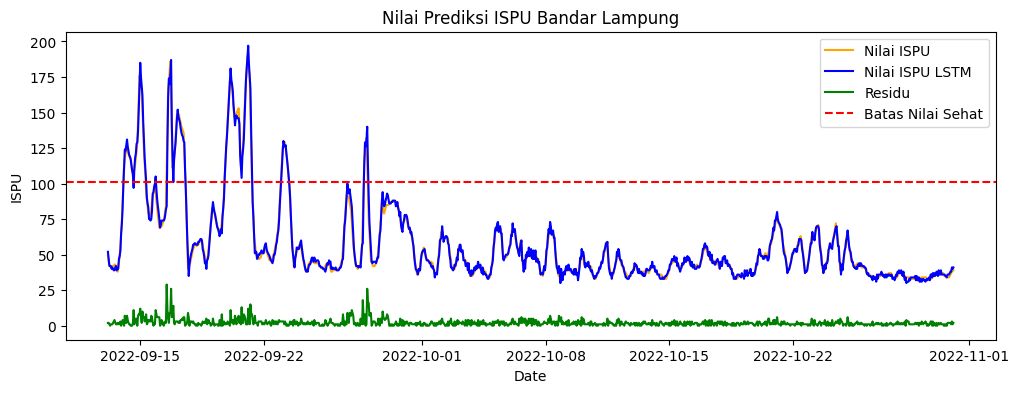

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
# fig.set_size_inches(8.90, 1.18)
plt.figure(figsize=(12,4))
# plt.figure(figsize=(9,3))
# plt.rcParams.update({
#         "font.size": 11,})
plt.plot(df_ISPU["ISPU_asli"], label='Nilai ISPU', color='orange')
plt.plot(df_ISPU["ISPU_pred"], label='Nilai ISPU LSTM', color='blue')
plt.plot(df_ISPU["residu"], label='Residu', color='green')
plt.axhline(y = 101, color = 'r', linestyle = 'dashed', label = 'Batas Nilai Sehat')
plt.title('Nilai Prediksi ISPU Bandar Lampung')
plt.legend(loc=0)
# line colour is red
plt.ylabel('ISPU')
plt.xlabel('Date')
#plt.legend(loc='upper righConvertISPU(dp)t')
plt.show();

In [ ]:
rmse = np.sqrt(mean_squared_error(df_ISPU['ISPU_asli'],df_ISPU['ISPU_pred']))
print(rmse)

3.2641252869473147


# Save Model

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
model.save('model_fix_weather.h5')